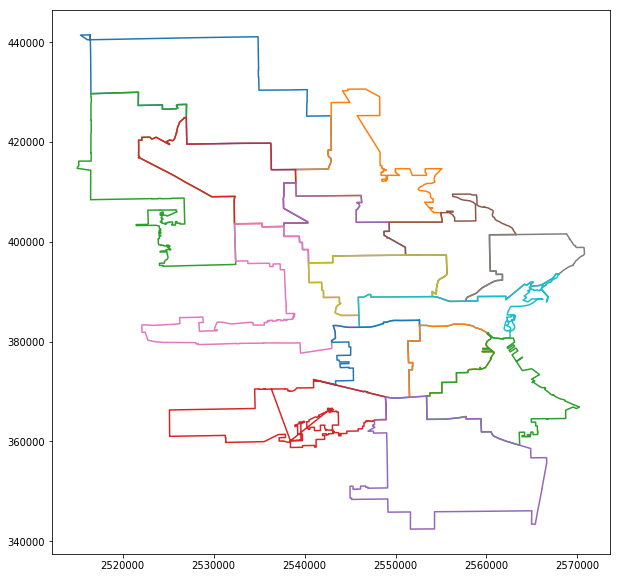

In [15]:
import shapefile
import matplotlib.pyplot as plt
%matplotlib inline

# got ald2012.shp from https://data.milwaukee.gov/dataset/aldermanic-districts

f = open('ald2012.shp', 'rb')
sf = shapefile.Reader(shp=f)
plt.figure(figsize=(10,10))
for i,dist in enumerate(sf.shapes()):
    xs = []
    ys = []
    for point in dist.points:
        coords = ['%.3f' % coord for coord in point]
        x = float(coords[0])
        y = float(coords[1])
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys, '-')
plt.show()